# Traffic Balancer

This notebook is used to implement loss minimization techniques for traffic balancing in a network.

## Goals:
- Implement a traffic balancer that minimizes the loss in a network, given a loss function.
- Implement stochastic gradient descent to minimize the loss function.
- Implemenet constraints

## Import the Graph

In [392]:
#the graph is stored as a pickle file, in a file called 'graph.gpickle'
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from collections import deque
import seaborn as sns
from tqdm import tqdm
import pickle

In [393]:
#read the graph from the file
#each code is a differeent graph with different starting conditions
# 1 - random graph
# 2 - linearly flow balanced graph
code = 1
with open('graph' + str(code) + '.gpickle', 'rb') as f:
    G = pickle.load(f)

In [394]:
#get the position from the file
code = 4
with open('pos' + str(code) + '.pkl', 'rb') as f:
    pos = pickle.load(f)

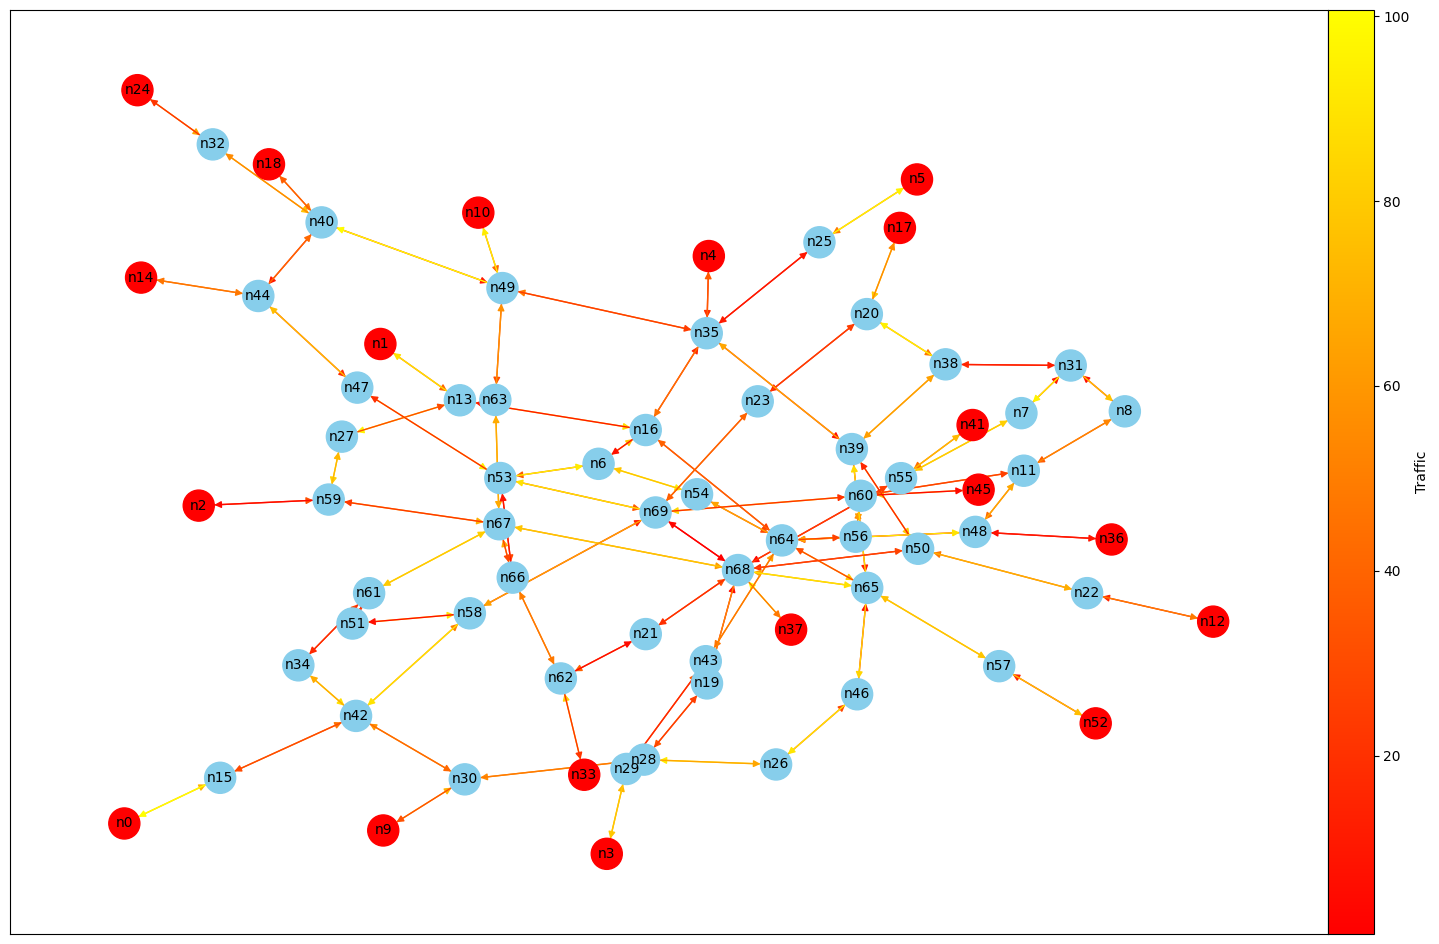

In [420]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming you have already defined G and pos

# Draw the graph
plt.figure(figsize=(20, 12))
# Create a colormap that is the second half of the copper colormap
cmap = plt.cm.autumn
# Draw the network with node colors and edge colors
nx.draw_networkx(G, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G.edges[edge]['traffic'] for edge in G.edges], edge_cmap=cmap, pos=pos)

# Get the current Axes instance
ax = plt.gca()

# Create a ScalarMappable to map numerical values to colors in the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min([G.edges[edge]['traffic'] for edge in G.edges]), vmax=max([G.edges[edge]['traffic'] for edge in G.edges])))

# Empty array to hold the values for the color bar
sm.set_array([])

# Add the color bar at the bottom of the plot
plt.colorbar(sm, ax=ax, label='Traffic', pad=-0, orientation='vertical')

# Show the plot
plt.show()


## Loss Functions

- We have 4 kinds of loss functions, and each are applied at different scales, and differ on what they are applied to.
    - Node Loss Function: The loss function for a single node
    - Global Node Loss Function: The loss function for the entire network
    - Edge Loss Function: The loss function for a single edge
    - Global Edge Loss Function: The loss function for the entire network
- Node Loss Functions are applied to a single node:
- Edge Loss Functions are applied to a single edge, and really only have one type of structure:
  - Two-Way Traffic Disparity: This loss functions represents the fact that ideally, edges have equal traffic in both directions.
- Global Node Loss Functions are applied to the entire network, and are weighted by total traffic at a node to make larger nodes more important.
- Global Edge Loss Functions are applied to the entire network, and are weighted by total traffic on an edge to make larger edges more important.

In [396]:
#Lets define our node loss function
#Loss can be measured as the standard deviation of the traffic values flowing out of the node, into the node, or both
#we will define the function with a parameter 'direction' which can be 'in', 'out', or 'both'
def nodeLoss(G,node, direction):
    #if an edge has 4 lanes, then it needs to repeat the traffic value 4 times when calculating the standard deviation
    #so we will create a list of traffic values for each edge, and then flatten the list
    if direction == 'in':
        traffic = [G.edges[edge]['traffic'] for edge in G.in_edges(node) for i in range(G.edges[edge]['lanes'])]
    elif direction == 'out':
        traffic = [G.edges[edge]['traffic'] for edge in G.out_edges(node) for i in range(G.edges[edge]['lanes'])]
    elif direction == 'both':
        traffic = [G.edges[edge]['traffic'] for edge in G.in_edges(node) for i in range(G.edges[edge]['lanes'])] + [G.edges[edge]['traffic'] for edge in G.out_edges(node) for i in range(G.edges[edge]['lanes'])]
    else:
        raise ValueError('direction must be in, out, or both')
    #return both the standard deviation and the total traffic
    return np.std(traffic)

In [397]:

#Lets define our edge loss function
#Loss can be measured as the absolute difference between the traffic values flowing out of the edge and the traffic values flowing into the edge
def edgeLoss(G, edge):
    u,v = edge
    #return both the absolute difference and the total traffic
    return abs(G.edges[u,v]['traffic'] - G.edges[v,u]['traffic']), G.edges[u,v]['traffic'] + G.edges[v,u]['traffic']

In [398]:
#lets define a function to calculate the total loss of the graph
def totalNodeLoss(G):
    #take the weighted sum of the node loss of all the nodes, weighted by the total traffic flowing through the node
    return np.sum([(nodeLoss(G, node, 'both') * G.nodes[node]['traffic'])for node in G.nodes])

def totalEdgeLoss(G):
    #take the weighted sum of the edge loss of all the edges, weighted by the total traffic flowing through the edge
    return np.sum([(edgeLoss(G, edge)[0] * edgeLoss(G, edge)[1]) for edge in G.edges])
    #technically, the edge loss is the same for both directions, so we can just take the average of the edge loss of all the edges

def totalTraffic(G):
    #sum up the traffic of all the edges
    return np.sum([G.edges[edge]['traffic'] * G.edges[edge]['lanes'] for edge in G.edges])

In [399]:
print('Total node loss:', totalNodeLoss(G))
print('Total edge loss:', totalEdgeLoss(G))
print('Total traffic:', totalTraffic(G))

Total node loss: 1054795.525021612
Total edge loss: 573676.0
Total traffic: 20990.0


## Loss Function Gradients

In [400]:
#we want to calculate the gradient for each traffic value in the graph
#we are going to do this by looking at the change in node loss when we change the traffic value by a small amount on the 2 nodes that the edge connects
#we will return the gradient that minimizes the total node loss

#lets define a function to calculate the gradient for a single edge
def edgeGradient(G, edge, epsilon=1):
    #we will pertiurb the traffic in both directions by a small amount, and calcaulte the change in node loss on both nodes

    #first, we will calculate the node loss on both nodes
    node1 = edge[0]
    node2 = edge[1]
    node1Loss = nodeLoss(G, node1, 'both')
    node2Loss = nodeLoss(G, node2, 'both')

    #then, we will perturb the traffic on the edge in both directions
    #first, lets find the positive perturbation
    G.edges[edge]['traffic'] += epsilon
    #find the new node loss on both nodes
    node1LossPos = nodeLoss(G, node1, 'both')
    node2LossPos = nodeLoss(G, node2, 'both')
    f_plus = node1LossPos + node2LossPos - node1Loss - node2Loss
    #then, lets find the negative perturbation
    G.edges[edge]['traffic'] -= 2 * epsilon
    #find the new node loss on both nodes
    node1LossNeg = nodeLoss(G, node1, 'both')
    node2LossNeg = nodeLoss(G, node2, 'both')
    f_minus = node1LossNeg + node2LossNeg - node1Loss - node2Loss
    #then, lets find the gradient
    return (f_plus - f_minus) / (2 * epsilon)


#lets define a function to calculate the gradient for the entire graph
def graphGradient(G, epsilon=1):
    #calculate the gradient for each edge
    epsilon = random.uniform(-epsilon, epsilon)
    gradients = [edgeGradient(G, edge, epsilon) for edge in G.edges]
    return gradients


In [401]:
#test the gradient function
print('Gradient:', graphGradient(G))

Gradient: [-0.41132470459442505, -0.6519744815312727, 0.4479480392531551, -0.29456943964500143, -0.5169439247745848, -0.44433010488772445, 0.2561486665877666, -0.08028243536816346, 0.4968362368553584, -0.5457721856421438, 0.14458385449145278, -0.1881820896357809, -0.5012365371026696, 0.8414243405552698, -0.5366796456268311, 0.10711309775244643, -0.09749376393009154, -0.021232109359327952, -0.9755361509038982, 0.6767328398346965, 0.1418878162246132, 0.7039511715177984, 0.5553364240631004, 0.856945024802932, -0.2166650751017536, -0.4659989880394495, -0.12237149159419253, -0.08687956819656989, -0.3702492130772596, 0.5950591345691667, 0.4970270752691139, -0.07363644354518332, -0.5386563312740335, -0.5075909156064793, -0.10883846309457054, -0.40741816963254823, 0.2019506160656049, 0.1970885282443575, 0.7991851576299872, 0.09965813257484112, -0.2632641651743398, 0.05311779140108069, 0.7219786732154042, 0.8844377038337199, -0.2625495602344832, 0.6349605916713842, -0.5814492758261287, -0.75061

Edge: ('n61', 'n51')
Traffic: 20.687335651739374
Node 1: n61 Node 2: n51
Node 1 traffic: 777.0 Node 2 traffic: 375.0


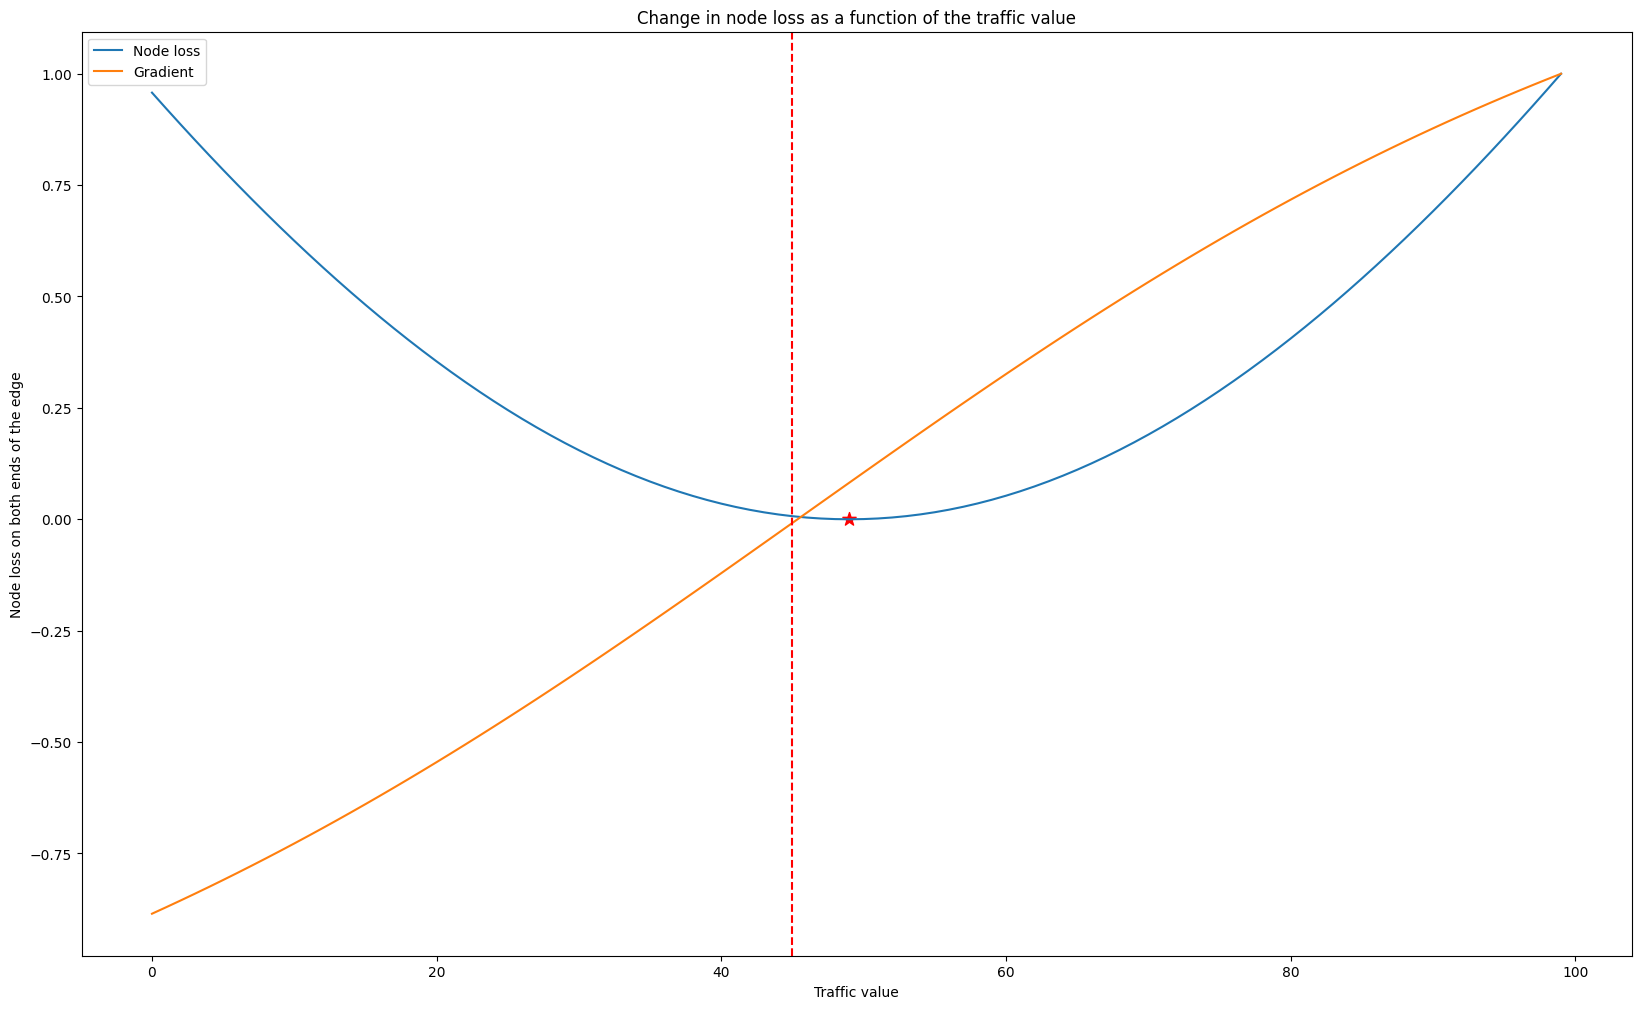

In [402]:
#pick a random edge, and simulate the change in node loss as we change the traffic value over a range of values
edge = random.choice(list(G.edges))
print('Edge:', edge)
print('Traffic:', G.edges[edge]['traffic'])
print('Node 1:', edge[0], 'Node 2:', edge[1])
print('Node 1 traffic:', G.nodes[edge[0]]['traffic'], 'Node 2 traffic:', G.nodes[edge[1]]['traffic'])

#try 100 different values, and calculate the change in node loss for each value
#we will plot the change in node loss as a function of the traffic value
#we will also plot the gradient as a function of the traffic value

losses = []
gradients = []
originalTraffic = G.edges[edge]['traffic']

for i in range(100):
    #perturb the traffic value
    G.edges[edge]['traffic'] = i
    #calculate the node loss
    losses.append((nodeLoss(G, edge[0], 'both') * G.nodes[edge[0]]['traffic'] + nodeLoss(G, edge[1], 'both') * G.nodes[edge[1]]['traffic'] ))
    #calculate the gradient
    gradients.append(edgeGradient(G, edge, 0.5))

#reset the traffic value
G.edges[edge]['traffic'] = originalTraffic

#standardize the losses and gradients so that they are between 0 and 1
losses = (losses - np.min(losses)) / (np.max(losses) - np.min(losses))
gradients = gradients / np.max(np.abs(gradients))

#plot the change in node loss as a function of the traffic value
plt.figure(figsize=(20, 12))
plt.plot(range(100), losses)
plt.plot(range(100), gradients)
#add a line at the point where the gradient is 0
plt.axvline(x=np.argmin(np.abs(gradients)), color='r', linestyle='--')
#add a star where the loss is minimized
plt.scatter(np.argmin(losses), np.min(losses), marker='*', s=100, color='r')
plt.xlabel('Traffic value')
plt.ylabel('Node loss on both ends of the edge')
plt.title('Change in node loss as a function of the traffic value')
plt.legend(['Node loss', 'Gradient'])
plt.show()


## Balancing Methods:
- There are two types of Balancing Methods:
  - Input/Output balancers: These loss functions are applied to the input/output of a node, and equalize the input/output traffic of a node.
    - These loss functions must be applied to both input and output to affect the network. Otherwise, the network will simply shift once, as traffic from one node simply doesn't affect the other node.
  - Reflows: These sum the input traffic of a node, and then distribute it evenly to the output traffic of a node.
    - These loss functions have a much more simple impact on the network, as they only need to be applied to the output of a node, but they overwrite node output traffic.
    - This can result in network wide ballooning or zeroing of traffic, as the total traffic of a node is not preserved.
- Balancing methods are applied node-wise, and are applied to the input/output of a node.
  - Most likely, we will apply them to a random first node, and then apply to its neighbors, and then apply to the neighbors of the neighbors, and so on.
  - One Epoch is defined as one application of the balancing method to every node in the network.

### METHOD 1: INPUT/OUTPUT BALANCERS

#### Input/Output Balancer 1: Lane Equalizer

In [403]:
def balance(G, node):
    '''
    This function balances the traffic flowing into and out of a node.
    It does this by making the traffic on every lane of every edge flowing into the node equal to the weighted average of the traffic flowing into the node.
    aka, it averages the traffic in and traffic out.
    '''
    if G.nodes[node]['border']:
        #if the node is a border node, then we can't balance it
        return
    elif G.nodes[node]['borderedge']:
        #we remove border edges from consideration when balancing
        inlane = (G.nodes[node]['traffic_in'] - G.nodes[node]['border_in']) / (G.nodes[node]['lanes_in'] - G.nodes[node]['border_in_lanes'])
        outlane = (G.nodes[node]['traffic_out'] - G.nodes[node]['border_out']) / (G.nodes[node]['lanes_out'] - G.nodes[node]['border_out_lanes'])
        for edge in G.out_edges(node):
            if not G.edges[edge]['border']:
                G.edges[edge]['traffic'] = outlane
        for edge in G.in_edges(node):
            if not G.edges[edge]['border']:
                G.edges[edge]['traffic'] = inlane
    else:
        inlane = G.nodes[node]['traffic_in'] / G.nodes[node]['lanes_in']
        outlane = G.nodes[node]['traffic_out'] / G.nodes[node]['lanes_out']
        for edge in G.out_edges(node):
            G.edges[edge]['traffic'] = outlane
        for edge in G.in_edges(node):
            G.edges[edge]['traffic'] = inlane

    for edge in G.out_edges(node):
        G.nodes[edge[1]]['traffic_in'] = sum(G.edges[edge]['traffic'] * G.edges[edge]['lanes'] for edge in G.in_edges(edge[1]))
        G.nodes[edge[1]]['traffic'] = G.nodes[edge[1]]['traffic_in'] + G.nodes[edge[1]]['traffic_out']
    for edge in G.in_edges(node):
        G.nodes[edge[0]]['traffic_out'] = sum(G.edges[edge]['traffic'] * G.edges[edge]['lanes'] for edge in G.out_edges(edge[0]))
        G.nodes[edge[0]]['traffic'] = G.nodes[edge[0]]['traffic_in'] + G.nodes[edge[0]]['traffic_out']

    return list(G.neighbors(node))


### METHOD 2: REFLOWS

#### Reflow 1: Input/Output Linear Equalizer

In [404]:
def balance(G, node):
    '''
    This function equalizes the traffic flowing into and out of a node.
    All traffic in must flow out, and it balances the traffic out by the lanes.
    '''
    #if the node is a border node, then we can't balance it
    if G.nodes[node]['border']:
        return
    elif G.nodes[node]['borderedge']:
        #we remove border edges from consideration when balancing
        outlane = (G.nodes[node]['traffic_in'] - G.nodes[node]['border_in']) / (G.nodes[node]['lanes_out'] - G.nodes[node]['border_out_lanes'])
        for edge in G.out_edges(node):
            if not G.edges[edge]['border']:
                G.edges[edge]['traffic'] = outlane
    else:
        #We make all the in traffic flow out. Hopefully, we don't lose any traffic in the process
        outlane = G.nodes[node]['traffic_in'] / G.nodes[node]['lanes_out']
        for edge in G.out_edges(node):
            G.edges[edge]['traffic'] = outlane
        
    for edge in G.out_edges(node):
        G.nodes[edge[1]]['traffic_in'] = sum(G.edges[edge]['traffic'] * G.edges[edge]['lanes'] for edge in G.in_edges(edge[1]))
        G.nodes[edge[1]]['traffic'] = G.nodes[edge[1]]['traffic_in'] + G.nodes[edge[1]]['traffic_out']

    return list(G.neighbors(node))

### METHOD 3: Gradient Node Rebalancing

##### Gradient Node Rebalancing 1: Lagrange Multiplier

$$s = T(\text{node}) - l_i * t_i$$
$$r = 1 - \frac{l_i}{n}$$ 
$$h = \frac{l_i}{n}$$
$$ C = \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}\frac{2s_{\alpha}r_{\alpha}}{n_{\alpha}} + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}\frac{2s_{\beta}r_{\beta}}{n_{\beta}} $$
$$ t_i \left( \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}[2r_{\alpha}^{2}] + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}[2r_{\beta}^{2}] \right) - \lambda = C $$

In [405]:
def lagrange_coefficients(G, edge):
    #calculate n
    n = (G.nodes[edge[0]]['lanes_in'] + G.nodes[edge[0]]['lanes_out'], G.nodes[edge[1]]['lanes_in'] + G.nodes[edge[1]]['lanes_out'])

    #calculate s
    #$$s = T(\text{node}) - l_i * t_i$$
    s = (G.nodes[edge[0]]['traffic'] - G.edges[edge]['traffic'] * G.edges[edge]['lanes'], G.nodes[edge[1]]['traffic'] - G.edges[edge]['traffic'] * G.edges[edge]['lanes'])

    #calculate r
    #$$r = 1 - \frac{l_i}{n}$$ 
    r = (1 - G.edges[edge]['lanes'] / n[0], 1 - G.edges[edge]['lanes'] / n[1])

    #calculate h
    #$$h = \frac{l_i}{n}$$
    h = (G.edges[edge]['lanes'] / n[0], G.edges[edge]['lanes'] / n[1])

    #calculate T(\alpha) / edges(\alpha) and T(\beta) / edges(\beta)
    #$$\frac{T(\alpha)}{\text{edges}(\alpha)} = \frac{T(\text{node})}{\text{edges}(\text{node})}$$
    T = (G.nodes[edge[0]]['traffic'] / n[0], G.nodes[edge[1]]['traffic'] / n[1])

    #calculate C
    #$$ C = \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}\frac{2s_{\alpha}r_{\alpha}}{n_{\alpha}} + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}\frac{2s_{\beta}r_{\beta}}{n_{\beta}} $$
    C = T[0] * h[0] * 2 * s[0] * r[0] / n[0] + T[1] * h[1] * 2 * s[1] * r[1] / n[1]
    
    #calculate the coefficient for t_i
    #$$ t_i \left( \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}[2r_{\alpha}^{2}] + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}[2r_{\beta}^{2}] \right) - \lambda = C $$
    coef = T[0] * h[0] * 2 * r[0] ** 2 + T[1] * h[1] * 2 * r[1] ** 2

    return coef, C

In [406]:
def lagrange(G):
    #make a copy of the graph
    G1 = G.copy()

    #calculate the coefficients for each edge
    coefficients = [lagrange_coefficients(G1, edge) for edge in G1.edges]
    
    #We will have two matrices, A and b.
    #A will be a matrix of the coefficients for each edge, with the first coef for each edge across the diagonal
    #b will be a matrix of the constants for each edge

    #initialize A and b
    A = np.diag([coef[0] for coef in coefficients])
    b = [coef[1] for coef in coefficients]

    #append the lane counts for every edge to the bottom of A
    A = np.vstack((A, [G1.edges[edge]['lanes'] for edge in G1.edges]))

    #add a column of -1s to A
    A = np.hstack((A, np.ones((len(A), 1))))

    #update the rows of A that correspond to border edges
    for i, edge in enumerate(G1.edges):
        if G1.edges[edge]['border']:
            #clear the row
            A[i, :] = 0
            #set the diagonal to 1
            A[i, i] = 1
            #set the last column to the original traffic value
            b[i] = G1.edges[edge]['traffic']

    #change the value at the bottom right corner to 0
    A[-1, -1] = 0

    #add the total traffic to the bottom of b
    b.append(totalTraffic(G1))

    #solve the system of equations
    x = np.linalg.solve(A, b)
    
    #assign the traffic values to the edges
    for i, edge in enumerate(G1.edges):
        G1.edges[edge]['traffic'] = x[i]
        

    #update the node traffic values
    for node in G1.nodes:
        G1.nodes[node]['traffic_in'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.in_edges(node))
        G1.nodes[node]['traffic_out'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.out_edges(node))
        G1.nodes[node]['traffic'] = G1.nodes[node]['traffic_in'] + G1.nodes[node]['traffic_out']

    return x[-1], G1

In [407]:
#test the lagrange function
mult, G_la = lagrange(G)
print('Multiplier:', mult)
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Multiplier: 9.08045122144053
Original graph vs balanced graph
Total node loss: 1054796 509643 48.32 %
Total edge loss: 581693 242009 41.6 %
Total traffic: 21294 21294 100.0 %
Total border traffic: 5178.0 5250.85757908437 101.4070602372416 %


In [408]:
#print the differnece in traffic on each border edge
for edge in G.edges:
    if G.edges[edge]['border']:
        print('Edge:', edge, 'Traffic:', G.edges[edge]['traffic'], G_la.edges[edge]['traffic'], G_la.edges[edge]['traffic'] / G.edges[edge]['traffic'] * 100, '%')

Edge: ('n0', 'n15') Traffic: 71.68733565173937 71.68733565173943 100.00000000000009 %
Edge: ('n1', 'n13') Traffic: 40.687335651739374 40.687335651739474 100.00000000000024 %
Edge: ('n2', 'n59') Traffic: 31.687335651739374 31.687335651739374 100.0 %
Edge: ('n3', 'n29') Traffic: 71.68733565173937 71.68733565173937 100.0 %
Edge: ('n4', 'n35') Traffic: 18.687335651739374 18.687335651739374 100.0 %
Edge: ('n5', 'n25') Traffic: 49.687335651739374 49.687335651739374 100.0 %
Edge: ('n9', 'n30') Traffic: 70.68733565173937 70.68733565173937 100.0 %
Edge: ('n10', 'n49') Traffic: 40.687335651739374 40.687335651739374 100.0 %
Edge: ('n12', 'n22') Traffic: 15.687335651739376 15.687335651738541 99.99999999999469 %
Edge: ('n13', 'n1') Traffic: 88.68733565173937 88.68733565173937 100.0 %
Edge: ('n14', 'n44') Traffic: 48.687335651739374 48.687335651739374 100.0 %
Edge: ('n15', 'n0') Traffic: 100.68733565173937 100.68733565173937 100.0 %
Edge: ('n17', 'n20') Traffic: 78.68733565173937 78.68733565173937 1

In [409]:
#test the lagrange function
mult, G_la = lagrange(G_la)
print('Multiplier:', mult)
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Multiplier: 15.831364987374837
Original graph vs balanced graph
Total node loss: 1054796 395538 37.5 %
Total edge loss: 581693 171668 29.51 %
Total traffic: 21294 21294 100.0 %
Total border traffic: 5178.0 5250.857579084364 101.40706023724148 %


In [410]:
#Try iterating the lagrange function

#init the progress bar
pbar = tqdm(total=100)
#do the first iteration
mult, G_la = lagrange(G)
#create an array to store the multipliers, and an array to store the total node loss
mults = [mult]
losses = [totalNodeLoss(G_la)]
for _ in range(100):
    mult, G_la = lagrange(G_la)
    mults.append(mult)
    losses.append(totalNodeLoss(G_la))
    pbar.update(1)
    G_la = G_la.copy()

pbar.close()

100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


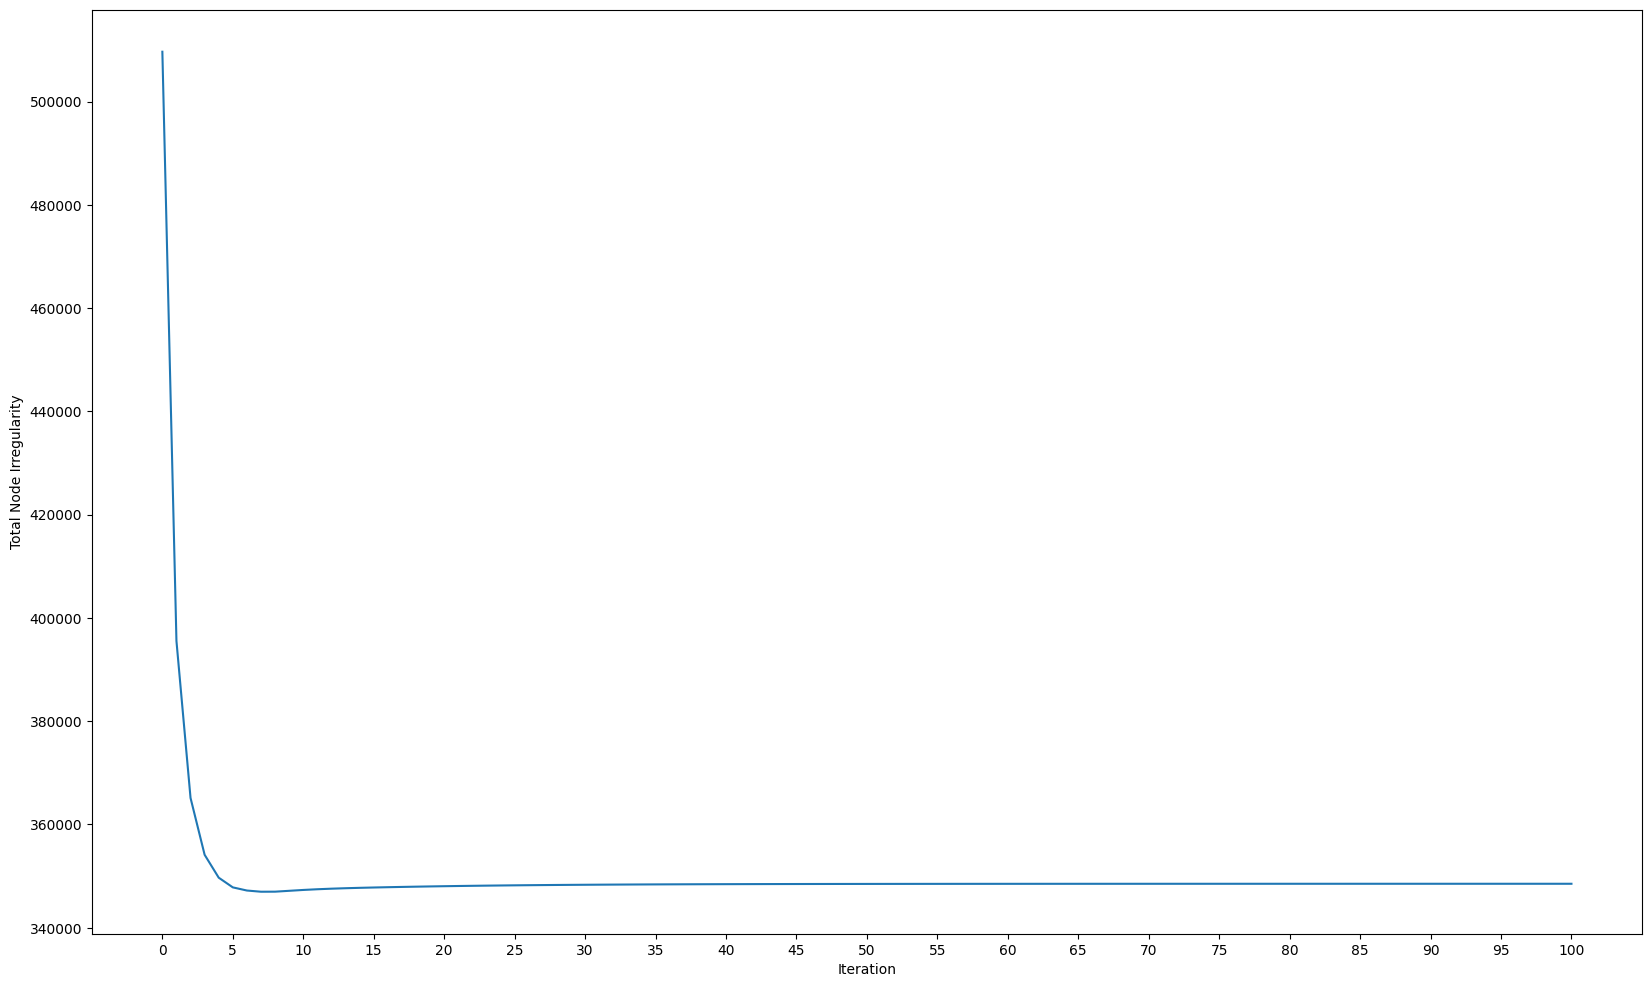

In [411]:

#plot the multipliers and the total node loss
plt.figure(figsize=(20, 12))
#plt.plot(range(len(mults)), mults)
plt.plot(range(len(losses)), losses)
#add labels
plt.xlabel('Iteration')
plt.ylabel('Total Node Irregularity')
#make the tick marks 5 iterations
plt.xticks(np.arange(0, len(losses), 5))
#plt.title('Total Node Irregularity vs Iteration')
plt.show()

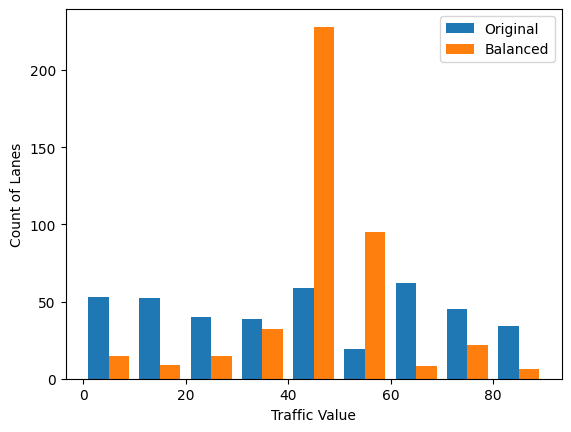

In [412]:
#compare the traffic distribution of the original graph and the balanced graph
#first, make a list of the traffic values of the edges of the original graph
traffic = [np.repeat(G.edges[edge]['traffic'], G.edges[edge]['lanes']) for edge in G.edges]
#then, make a list of the traffic values of the edges of the balanced graph
traffic2 = [np.repeat(G_la.edges[edge]['traffic'], G_la.edges[edge]['lanes']) for edge in G_la.edges]

traffic = np.concatenate(traffic)
traffic2 = np.concatenate(traffic2)

#now, make a histogram with both traffic distributions
plt.hist([traffic, traffic2], label = ['Original', 'Balanced'], bins=np.arange(0, 100, 10))
plt.xlabel('Traffic Value')
plt.ylabel('Count of Lanes')
#plt.title('Traffic Distribution')
plt.legend()
plt.show()

C:\Users\eamor\AppData\Local\Temp\ipykernel_24316\3776034996.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic, shade=True, label='Original')
C:\Users\eamor\AppData\Local\Temp\ipykernel_24316\3776034996.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic2, shade=True, label='Balanced')


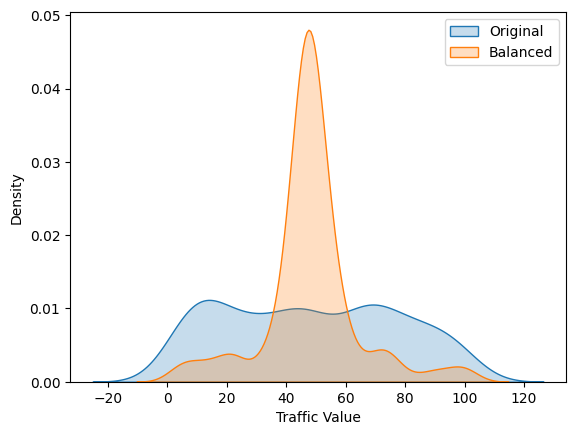

In [413]:
#desnity plot
sns.kdeplot(traffic, shade=True, label='Original')
sns.kdeplot(traffic2, shade=True, label='Balanced')
plt.xlabel('Traffic Value')
plt.ylabel('Density')
#plt.title('Traffic Distribution')
plt.legend()
plt.show()


In [414]:
#describe the traffic distribution of the original graph
print('Original graph')
print('Mean:', np.mean(traffic))
print('Median:', np.median(traffic))
print('Standard deviation:', np.std(traffic))
print('Min:', np.min(traffic))
print('Max:', np.max(traffic))

#describe the traffic distribution of the balanced graph
print('Balanced graph')
print('Mean:', np.mean(traffic2))
print('Median:', np.median(traffic2))
print('Standard deviation:', np.std(traffic2))
print('Min:', np.min(traffic2))
print('Max:', np.max(traffic2))


Original graph
Mean: 48.17602343454481
Median: 47.687335651739374
Standard deviation: 29.137699431189475
Min: 0.6873356517393752
Max: 100.68733565173937
Balanced graph
Mean: 48.17602343454445
Median: 47.8380406186104
Standard deviation: 15.913060286877883
Min: 3.687335651739375
Max: 100.68733565173937


In [415]:
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Original graph vs balanced graph
Total node loss: 1054796 348520 33.04 %
Total edge loss: 581693 140728 24.19 %
Total traffic: 21294 21294 100.0 %
Total border traffic: 5178.0 5250.857579084006 101.40706023723456 %


In [416]:
#plot the traffic distribution of the original graph
plt.figure(figsize=(20, 12))
nx.draw_networkx(G, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G.edges[edge]['traffic'] for edge in G.edges], edge_cmap=plt.cm.heat, pos=pos)

AttributeError: module 'matplotlib.cm' has no attribute 'heat'

<Figure size 2000x1200 with 0 Axes>

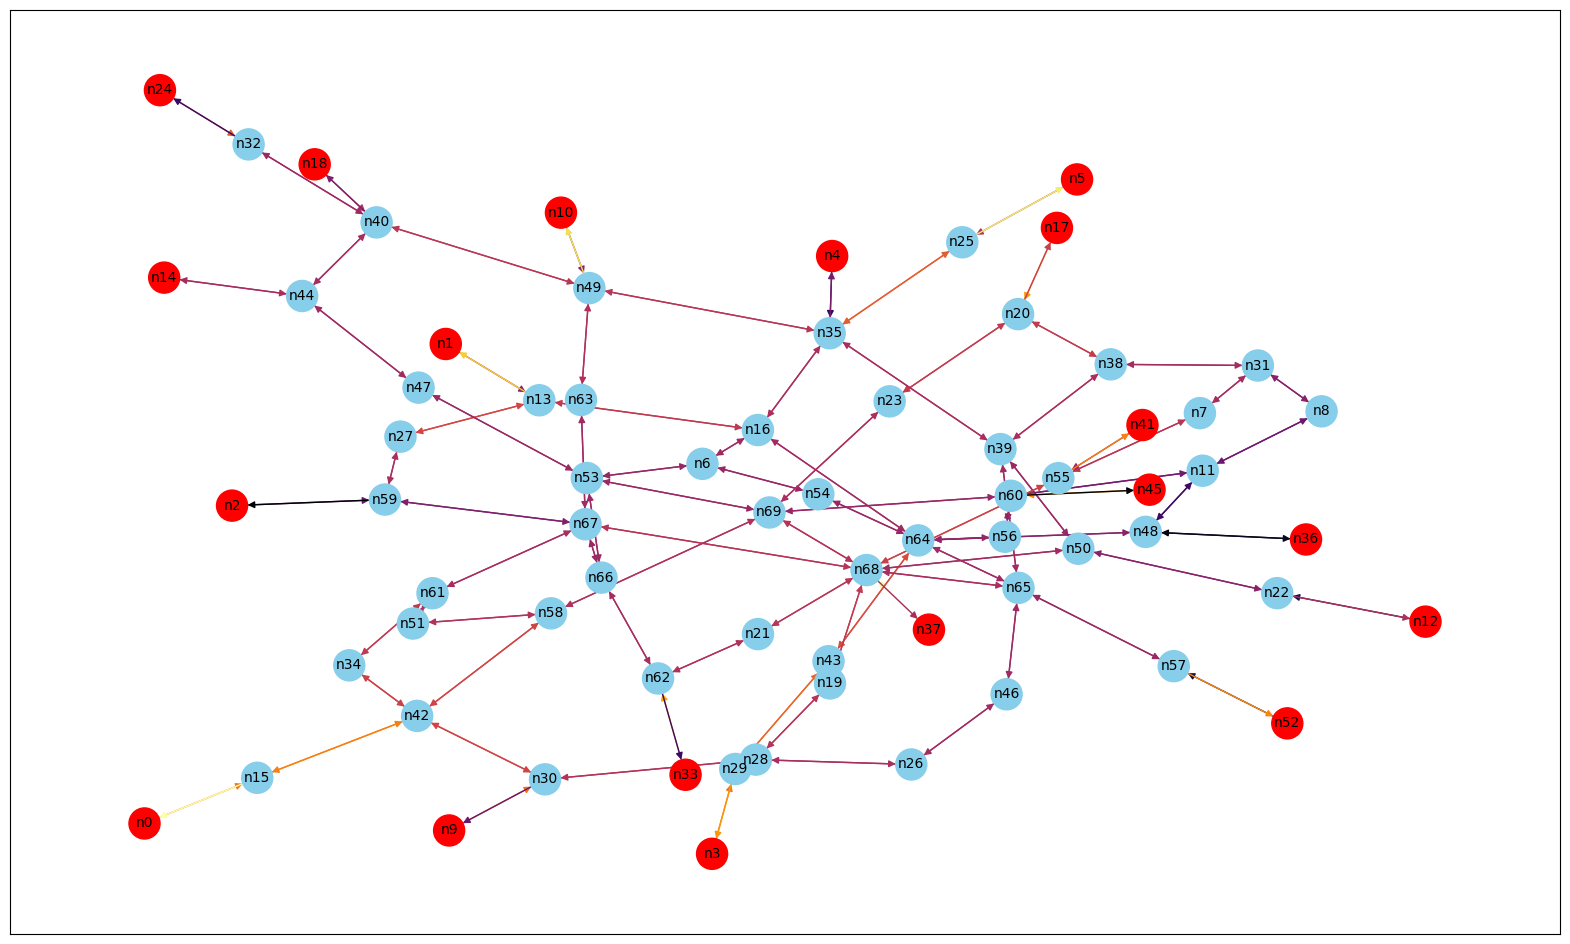

In [ ]:
plt.figure(figsize=(20, 12))
nx.draw_networkx(G_la, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G_la, 'border').values()), 'r', 'skyblue'), edge_color=[G_la.edges[edge]['traffic'] for edge in G_la.edges], edge_cmap=plt.cm.heat, pos=pos)

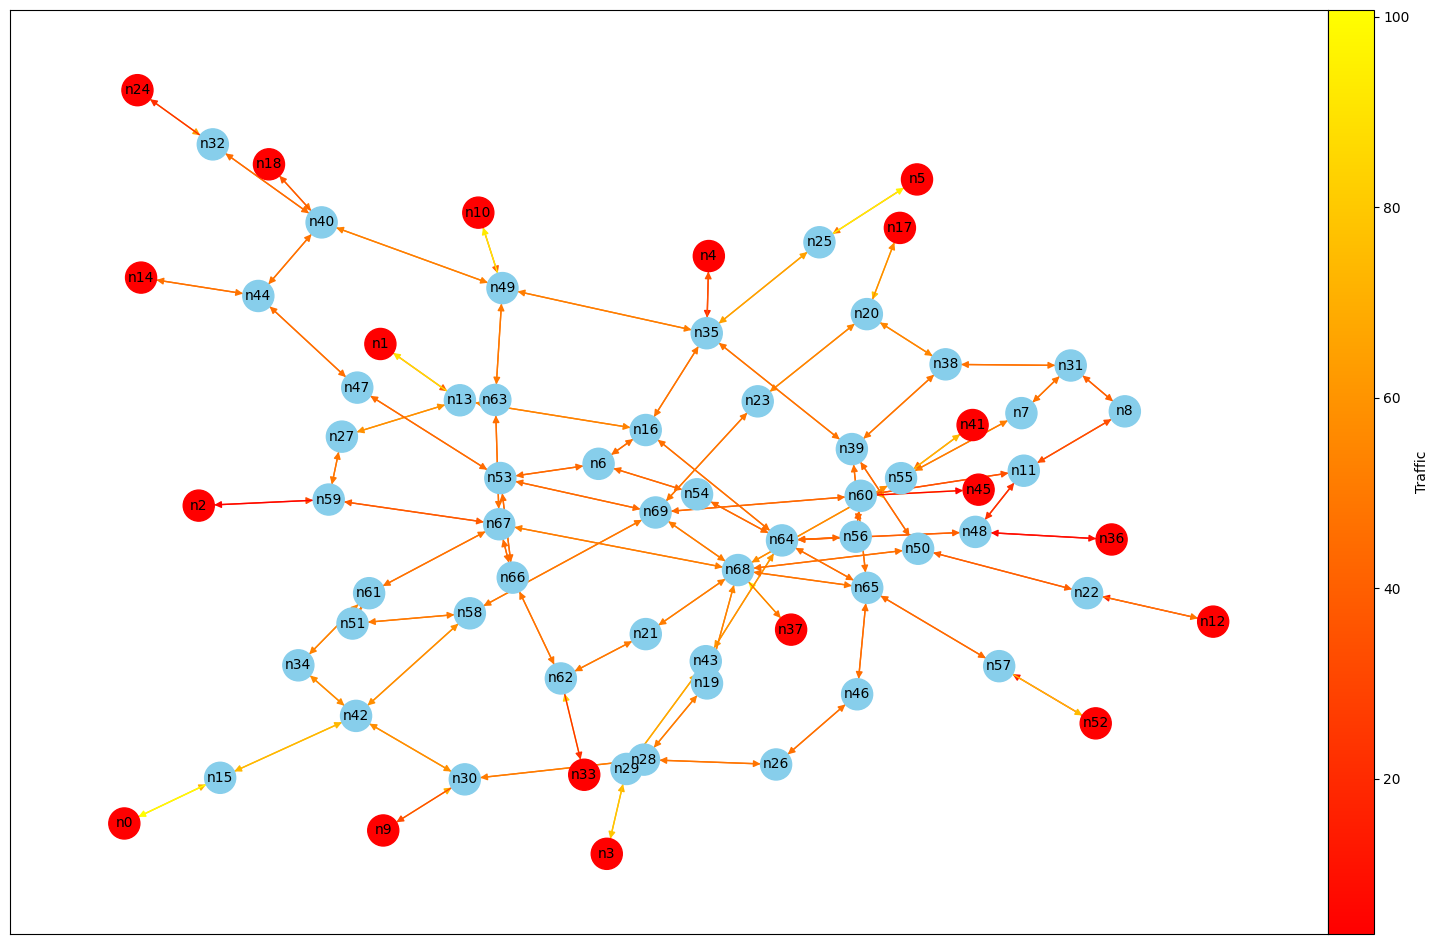

In [421]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming you have already defined G and pos

# Draw the graph
plt.figure(figsize=(20, 12))
# Create a colormap that is the second half of the copper colormap
cmap = plt.cm.autumn
# Draw the network with node colors and edge colors
nx.draw_networkx(G_la, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G_la.edges[edge]['traffic'] for edge in G_la.edges], edge_cmap=cmap, pos=pos)

# Get the current Axes instance
ax = plt.gca()

# Create a ScalarMappable to map numerical values to colors in the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min([G_la.edges[edge]['traffic'] for edge in G_la.edges]), vmax=max([G.edges[edge]['traffic'] for edge in G_la.edges])))

# Empty array to hold the values for the color bar
sm.set_array([])

# Add the color bar at the bottom of the plot
plt.colorbar(sm, ax=ax, label='Traffic', pad=-0, orientation='vertical')

# Show the plot
plt.show()


#### Stochastic Gradient Descent

In [ ]:
def stochasticGradientDescent(G, epsilon=1):
    # Make a copy of the graph
    G1 = G.copy()

    #get the gradient
    grad = graphGradient(G1)

    #get the total traffic
    total_traffic = totalTraffic(G1)

    #apply the gradient to the edges
    for i, edge in enumerate(G1.edges):
        G1.edges[edge]['traffic'] -= grad[i] * epsilon

    #calculate the total traffic
    new_total_traffic = totalTraffic(G1)

    #find the deviation per lane
    deviation =  (total_traffic - new_total_traffic) / sum([G1.edges[edge]['lanes'] for edge in G1.edges])

    #apply the deviation to the edges
    for edge in G1.edges:
        G1.edges[edge]['traffic'] += deviation

    print(sum([G1.edges[edge]['traffic'] for edge in G1.edges]) - total_traffic)

    #update the traffic values for each node
    for node in G1.nodes:
        G1.nodes[node]['traffic_in'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.in_edges(node))
        G1.nodes[node]['traffic_out'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.out_edges(node))
        G1.nodes[node]['traffic'] = G1.nodes[node]['traffic_in'] + G1.nodes[node]['traffic_out']

    return G1

                           

In [ ]:
desc = stochasticGradientDescent(G)

-12498.390518312273


In [ ]:
#test the gradient descent function
desc = stochasticGradientDescent(G)
for _ in range(100):
    desc = stochasticGradientDescent(desc)


-12830.011287845295
-12947.060598791346
-13200.49812798596
-13095.570773676844
-13360.287255876643
-13151.32371777504
-13170.764764096164
-13091.534710208212
-13156.071585313583
-12947.623329099648
-13132.30377481982
-13074.448826050839
-13178.419808344555
-13014.20342906901
-13151.4101520852
-13402.3087409967
-13154.08336817146
-13184.544046239636
-13283.869971105805
-13348.931985142088
-13409.777878095943
-13422.480020828727
-13334.380631971573
-13170.3108600207
-13190.6863167932
-12937.070538073154
-12820.391087101589
-12620.01390372865
-12789.046456074822
-12588.757468929918
-12455.166896326253
-12544.857480190936
-12474.636931233013
-12304.807542754417
-12257.110718417729
-12465.916242518168
-12448.046200546665
-12299.061561540764
-12030.556868320553
-12110.400558741672
-12225.465309239902
-12296.966060783001
-12453.215941677558
-12194.524221634958
-11984.743682010572
-11853.033436346757
-11914.167794337165
-11863.595437867523
-11868.964984249531
-11968.966248153938
-11841.4183858

In [ ]:
#look at the total node loss, edge loss and traffic
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(desc)), round(totalNodeLoss(desc) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', totalEdgeLoss(G), round(totalEdgeLoss(desc)), round(totalEdgeLoss(desc) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', totalTraffic(G), round(totalTraffic(desc)), round(totalTraffic(desc) / totalTraffic(G) * 100, 2), '%')

Original graph vs balanced graph
Total node loss: 1054796 137916 13.08 %
Total edge loss: 567695.0807841441 41036 7.23 %
Total traffic: 20763.356799261976 18873 90.9 %


## Graph-Wide Balancer

### METHOD 1: NEIGHBOR BALANCERS

#### Neighbor Balancer 1: One-Hit with Neighbor Priority

In [ ]:
def balanceGraph(G, iterations=1000):
    '''
    Hits every single node once per epoch, prioritizing the neighbors of the recently updated node.
    '''
    queue = deque()
    balanced = set()
    losses = []
    num_nodes = len(G.nodes)

    for _ in range(iterations):
        start = time.time()

        node = random.choice([node for node in G.nodes if not G.nodes[node]['border']])
        queue.append(node)

        while queue:
            node = queue.popleft()
            neighbors = balance(G, node)
            try:
                neighbors = {neighbor for neighbor in neighbors if neighbor not in balanced}
                queue.extendleft(neighbors)
            except:
                pass

            balanced.add(node)

            if not queue and len(balanced) < num_nodes:
                node = random.sample(set(G.nodes) - balanced, 1)[0]
                queue.append(node)

            elif len(balanced) == num_nodes:
                break

        balanced.clear()
        queue.clear()

        losses.append((totalEdgeLoss(G), totalNodeLoss(G)))
        print('Iteration', _ + 1, 'took', time.time() - start, 'seconds')

    return G, losses

#### Neighbor Balancer 2: Multi-Hit with Neighbor Priority

In [ ]:
def balanceGraph(G, iterations=1000, epoch_multiplier=1):
    '''
    Hits epoch_multiplier * len(G.nodes) nodes per epoch, prioritizing the neighbors of the recently updated node.
    Not guaranteed to hit every node in the graph, but will hit most of them.
    '''
    queue = deque()
    losses = []

    for _ in range(iterations):
        start = time.time()
        count = int(epoch_multiplier * len(G.nodes))

        node = random.choice([node for node in G.nodes if not G.nodes[node]['border']])
        queue.append(node)

        while queue:
            node = queue.popleft()
            neighbors = balance(G, node)
            count -= 1
            try:
                queue.extendleft(neighbors)
            except:
                pass

            if not queue:
                node = random.choice(set([node for node in G.nodes if not G.nodes[node]['border']]))[0]
                queue.append(node)

            elif count == 0:
                break

        queue.clear()

        losses.append((totalEdgeLoss(G), totalNodeLoss(G)))
        print('Iteration', _ + 1, 'took', time.time() - start, 'seconds')

    return G, losses

## Testing

In [ ]:
#make a copy of the graph, so we can modify it
G2 = G.copy()
#balance the graph
G2, losses = balanceGraph(G2, 1000, 1)


Iteration 1 took 0.009002685546875 seconds
Iteration 2 took 0.007997274398803711 seconds
Iteration 3 took 0.00800180435180664 seconds
Iteration 4 took 0.009001731872558594 seconds
Iteration 5 took 0.00799703598022461 seconds
Iteration 6 took 0.009002447128295898 seconds
Iteration 7 took 0.008154630661010742 seconds
Iteration 8 took 0.009354352951049805 seconds
Iteration 9 took 0.008998870849609375 seconds
Iteration 10 took 0.0086212158203125 seconds
Iteration 11 took 0.007999181747436523 seconds
Iteration 12 took 0.007012605667114258 seconds
Iteration 13 took 0.008987188339233398 seconds
Iteration 14 took 0.007999420166015625 seconds
Iteration 15 took 0.007002353668212891 seconds
Iteration 16 took 0.01100015640258789 seconds
Iteration 17 took 0.008072137832641602 seconds
Iteration 18 took 0.008925676345825195 seconds
Iteration 19 took 0.007999897003173828 seconds
Iteration 20 took 0.00800180435180664 seconds
Iteration 21 took 0.007074594497680664 seconds
Iteration 22 took 0.01101183891

In [ ]:
#look at the total node loss, edge loss and traffic
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G2)), round(totalNodeLoss(G2) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', totalEdgeLoss(G), round(totalEdgeLoss(G2)), round(totalEdgeLoss(G2) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', totalTraffic(G), round(totalTraffic(G2)), round(totalTraffic(G2) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G2.nodes[node]['traffic'] for node in G2.nodes if G2.nodes[node]['border']]), np.sum([G2.nodes[node]['traffic'] for node in G2.nodes if G2.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')


Original graph vs balanced graph
Total node loss: 1054796 324931 30.81 %
Total edge loss: 567695.0807841441 142317 25.07 %
Total traffic: 20763.356799261976 18166 87.49 %
Total border traffic: 5178.0 5150.823326608336 99.47515115118455 %


### Loss Analysis

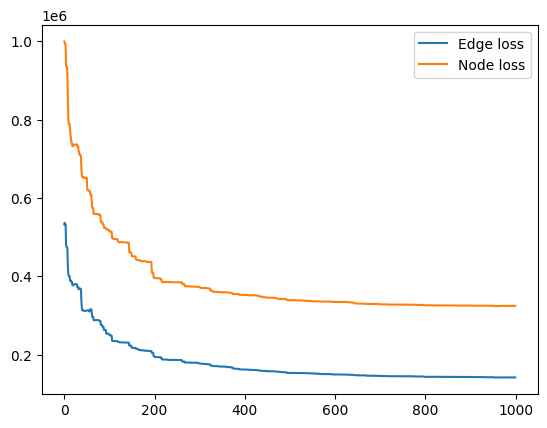

In [ ]:
#now, lets plot the losses
plt.plot([loss[0] for loss in losses], label = 'Edge loss')
plt.plot([loss[1] for loss in losses], label = 'Node loss')
plt.legend()

### Traffic Analysis

In [ ]:
#compare the traffic distribution of the original graph and the balanced graph
#first, make a list of the traffic values of the edges of the original graph
traffic = [G.edges[edge]['traffic'] for edge in G.edges]
#then, make a list of the traffic values of the edges of the balanced graph
traffic2 = [G2.edges[edge]['traffic'] for edge in G2.edges]

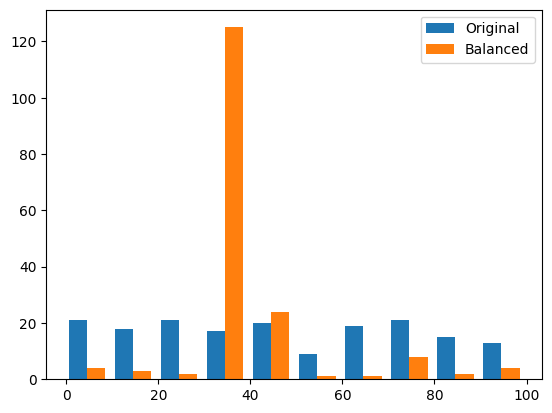

In [ ]:
#now, make a histogram with both traffic distributions
plt.hist([traffic, traffic2], bins = 10, label = ['Original', 'Balanced'])
#add a density line to the histogram
plt.legend()
plt.show()

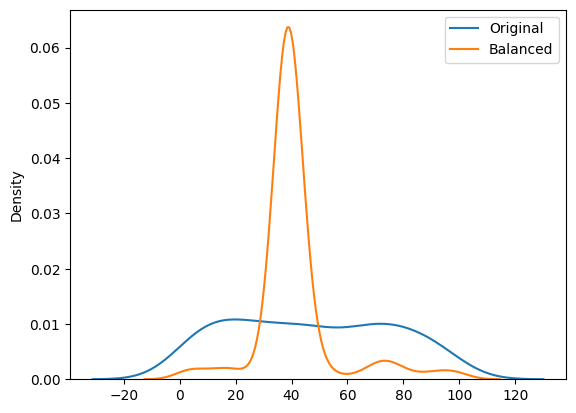

In [ ]:
#create a density plot of the traffic distribution of the original graph and the balanced graph, with sns
sns.kdeplot(traffic, label = 'Original')
sns.kdeplot(traffic2, label = 'Balanced')
plt.legend()

In [ ]:
#save the spring layout of the graph to a variable for later use
pos = nx.spring_layout(G2)

TypeError: draw() got multiple values for argument 'pos'

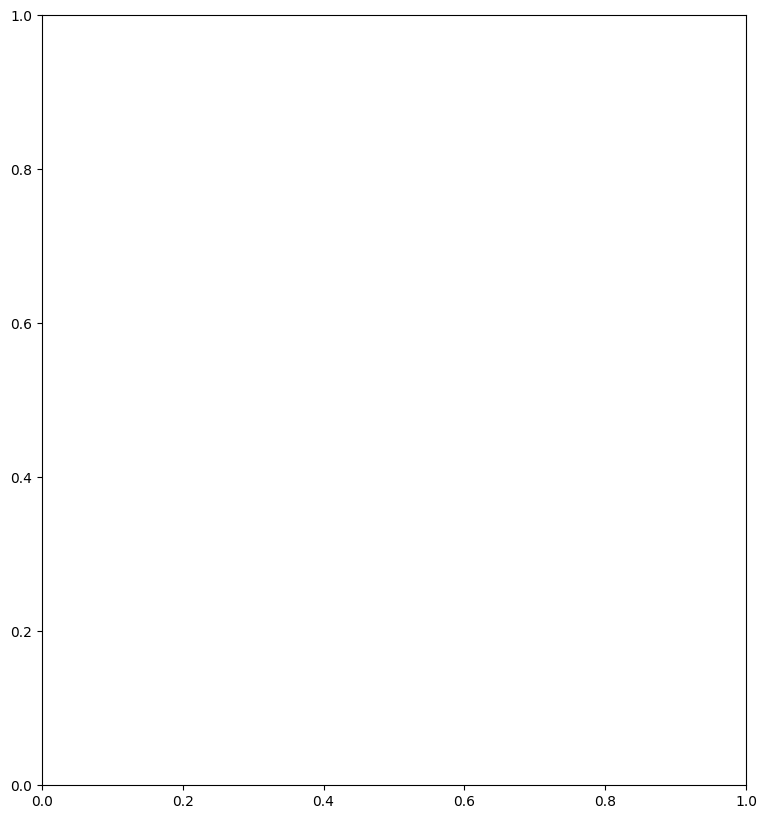

In [ ]:
#plot the original graph and the balanced graph
plt.figure(figsize=(20, 10))
#subplot 1
plt.subplot(121)
nx.draw(G, pos, node_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=traffic, edge_cmap=plt.cm.heat, pos=pos)
plt.title('Original graph')
#subplot 2
plt.subplot(122)
nx.draw(G2, pos, node_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=traffic2, edge_cmap=plt.cm.heat, pos=pos)
plt.title('Balanced graph')

plt.show()